# **Instalacion e importacion de librerias**

In [ ]:
!pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from wordcloud import WordCloud
# to display images
from skimage import io
from collections import Counter
from ast import literal_eval
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
import string
import re
from nltk.stem.snowball import SnowballStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Lectura/carga de principales datasets**

In [ ]:
dfMovies2 =  pd.read_csv('/content/drive/MyDrive/Proyecto ia2/movies.csv')
metadata = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/movies_metadata.csv')

credits = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/keywords.csv')


<ipython-input-4-5ce1fb04b0df>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/movies_metadata.csv')


# **Preprocessing**

In [ ]:
metadata=metadata.drop([19730,29503,35587]) # Incorrect data type


Conversion de ID a int

In [ ]:
dfMovies2['id']=dfMovies2['id'].astype('int')
metadata['id']=metadata['id'].astype('int')
credits['id']=credits['id'].astype('int')
keywords['id']=keywords['id'].astype('int')
# dfMovies2['id']=dfMovies2['id'].astype('int')
# dfCredits['id']=dfCredits['id'].astype('int')

In [ ]:
dfMovies2.columns

Index(['id', 'imdb_id', 'title', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'release_date', 'budget',
       'revenue', 'runtime', 'status', 'tagline', 'vote_average', 'vote_count',
       'credits', 'keywords', 'poster_path', 'backdrop_path',
       'recommendations'],
      dtype='object')

In [ ]:
# dfMovies2.columns

In [ ]:
# dfMovies2['adult'].value_counts()

Drop 'poster_path' de metadata (contiene path desactualizados)

In [ ]:
metadata= metadata.drop(columns=['poster_path'])

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45460 non-null  object 
 11  production_companies   45460 non-null  object 
 12  production_countries   45460 non-null  object 
 13  release_date           45376 non-null  object 
 14  revenue                45460 non-null  float64
 15  ru

MERGE POSTER PATH actualizados de dfMovies2 en metadata

In [ ]:
merged_df = pd.merge(metadata, dfMovies2[['id', 'poster_path']], on='id', how='inner')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57511 entries, 0 to 57510
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  57511 non-null  object 
 1   belongs_to_collection  5442 non-null   object 
 2   budget                 57511 non-null  object 
 3   genres                 57511 non-null  object 
 4   homepage               11415 non-null  object 
 5   id                     57511 non-null  int64  
 6   imdb_id                57504 non-null  object 
 7   original_language      57496 non-null  object 
 8   original_title         57511 non-null  object 
 9   overview               56494 non-null  object 
 10  popularity             57505 non-null  object 
 11  production_companies   57505 non-null  object 
 12  production_countries   57505 non-null  object 
 13  release_date           57462 non-null  object 
 14  revenue                57505 non-null  float64
 15  ru

In [ ]:
merged_df.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,poster_path
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,/z46R8oShx61gXMrAmd7ptpVqNI0.jpg
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,/rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg


MERGE CREDITS Y KEYWORDS

In [ ]:
df = merged_df.merge(keywords, on='id').\
    merge(credits, on='id')


In [ ]:
df.shape

(59244, 27)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59244 entries, 0 to 59243
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  59244 non-null  object 
 1   belongs_to_collection  5565 non-null   object 
 2   budget                 59244 non-null  object 
 3   genres                 59244 non-null  object 
 4   homepage               11801 non-null  object 
 5   id                     59244 non-null  int64  
 6   imdb_id                59237 non-null  object 
 7   original_language      59229 non-null  object 
 8   original_title         59244 non-null  object 
 9   overview               58179 non-null  object 
 10  popularity             59235 non-null  object 
 11  production_companies   59235 non-null  object 
 12  production_countries   59235 non-null  object 
 13  release_date           59192 non-null  object 
 14  revenue                59235 non-null  float64
 15  ru

In [ ]:
df['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

Drop columnas que no aportan valor

In [ ]:
df=df.drop(['belongs_to_collection', 'homepage', 'imdb_id', 'status', 'original_title', 'video'], axis=1)

Drop aquellas peliculas que no tengan titulo

In [ ]:
df = df[~df["title"].isna()]
# df = df[~df["overview"].isna()]

In [ ]:
df[df["title"].duplicated()]

,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,poster_path,keywords,cast,crew
51,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",117164,en,Detective - turned - bodyguard Cynthia McKay (...,0.595949,[],[],1994-11-22,...,93.0,[],She's no angel of mercy.,Guardian Angel,6.3,3.0,/AoRBM85EbRY9U0jtgy88DtV99Jl.jpg,[],"[{'cast_id': 1, 'character': 'Cynthia Mckay', ...","[{'credit_id': '52fe4babc3a36847f820ea31', 'de..."
57,False,0,[],124057,en,"Set in modern times, Alex finds King Arthur's ...",0.307075,"[{'name': 'Telefilm Canada', 'id': 7320}, {'na...",[],1997-07-08,...,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Kids of the Round Table,3.0,1.0,/1y8KAZOKrdmTI2sddcilcbRsMtI.jpg,[],"[{'cast_id': 1, 'character': 'Alex Cole', 'cre...","[{'credit_id': '57b42992c3a36875d50050d9', 'de..."
79,False,0,"[{'id': 99, 'name': 'Documentary'}]",124626,en,"A look into the many lives of Christa Päffgen,...",0.133893,"[{'name': 'Zweites Deutsches Fernsehen (ZDF)',...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-02-18,...,70.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",NaN,Nico Icon,7.3,3.0,/4qO219U8z1XeHLni800jCsbpSs0.jpg,[],"[{'cast_id': 14, 'character': 'Herself', 'cred...","[{'credit_id': '52fe4ab0c3a368484e161cd5', 'de..."
86,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",146599,en,This film relates the story of a tightly conne...,0.252287,"[{'name': 'BET Pictures', 'id': 38196}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-26,...,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Once Upon a Time... When We Were Colored,4.5,2.0,/45xucuNlia6vEPWYrYu2QlnwgpO.jpg,"[{'id': 6984, 'name': 'racial segregation'}, {...","[{'cast_id': 2, 'character': 'Poppa', 'credit_...","[{'credit_id': '52fe4b889251416c75106047', 'de..."
88,False,0,[],188588,en,"Filmed entirely on location in East Hampton, L...",0.531159,[],[],1995-11-22,...,108.0,[],NaN,Last Summer in the Hamptons,0.0,0.0,/g3m93gROYRRgu7lyQPzrka612uK.jpg,[],"[{'cast_id': 2, 'character': 'Oona Hart', 'cre...","[{'credit_id': '52fe4d3c9251416c7513477d', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59236,False,0,"[{'id': 878, 'name': 'Science Fiction'}]",222848,en,It's the year 3000 AD. The world's most danger...,0.661558,"[{'name': 'Concorde-New Horizons', 'id': 4688}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-01-01,...,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Caged Heat 3000,3.5,1.0,/qyiYbViulJm9RnZ5fkcKB3UN7ZE.jpg,[],"[{'cast_id': 1, 'character': 'Kira (as Cassand...","[{'credit_id': '5757f36ac3a3687d6f000e8a', 'de..."
59237,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,"Yet another version of the classic epic, with ...",5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Robin Hood,5.7,26.0,/3wvHxskniqALjqFBjHn6xPbUvzj.jpg,[],"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de..."
59239,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A deadly game of wits.,Betrayal,3.8,6.0,/t8QKZIMQ5lCpYKuLLxYG7pUcZE8.jpg,[],"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de..."
59241,False,0,[],227506,en,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,...,87.0,[],NaN,Satan Triumphant,0.0,0.0,/kmPJ4iJn3gtZyWCxCiuggl2kAuu.jpg,[],"[{'ca

Drop peliculas que tengan 'titulos' y 'release_date' duplicados, manteniendo el utlimo

In [ ]:
df = df[~df[["title","release_date"]].duplicated(keep='last')]


In [ ]:
df[df['title']=='The Dark Knight']

,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,poster_path,keywords,cast,crew
12627,False,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,Batman raises the stakes in his war on crime. ...,123.167259,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2008-07-16,...,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Why So Serious?,The Dark Knight,8.3,12269.0,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de..."
33343,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",72003,en,In a post-apocalyptic world ravaged by feuding...,0.077992,[],[],2011-07-11,...,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,The Dark Knight,6.3,2.0,/kq4VZAQy30Hs6kQV4NJk1nZHP50.jpg,[],"[{'cast_id': 2, 'character': 'Xan', 'credit_id...","[{'credit_id': '52fe4852c3a368484e0f2eed', 'de..."


Conversion de datos: 'budget', 'revenue', 'popularity' a tipo float64
Y 'release_date' a formato datetime

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['revenue'] = df['revenue'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

<ipython-input-28-5f7445b5c6d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'])


In [ ]:
# Hay datos nulos?
df.isnull().sum()

adult                       0
budget                      0
genres                      0
id                          0
original_language           8
overview                  673
popularity                  0
production_companies        0
production_countries        0
release_date               30
revenue                     0
runtime                   171
spoken_languages            0
tagline                 21460
title                       0
vote_average                0
vote_count                  0
poster_path               857
keywords                    0
cast                        0
crew                        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40831 entries, 0 to 59243
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 40831 non-null  object        
 1   budget                40831 non-null  float64       
 2   genres                40831 non-null  object        
 3   id                    40831 non-null  int64         
 4   original_language     40823 non-null  object        
 5   overview              40158 non-null  object        
 6   popularity            40831 non-null  float64       
 7   production_companies  40831 non-null  object        
 8   production_countries  40831 non-null  object        
 9   release_date          40801 non-null  datetime64[ns]
 10  revenue               40831 non-null  float64       
 11  runtime               40660 non-null  float64       
 12  spoken_languages      40831 non-null  object        
 13  tagline         

Estamos creando un sistema de recomendación de contenido y géneros, la descripción general es muy importante para encontrar películas similares. Así que eliminaré las películas que no tengan géneros ni descripción general 'overview'.

In [ ]:

index = df[(df['genres']=='') & (df['overview']=='')].index
index.shape

(0,)

In [ ]:
# droping those index
df.drop(index, inplace=True)

In [ ]:
df.head()

,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,poster_path,keywords,cast,crew
0,False,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7,5415.0,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,/z46R8oShx61gXMrAmd7ptpVqNI0.jpg,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,/rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40831 entries, 0 to 59243
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 40831 non-null  object        
 1   budget                40831 non-null  float64       
 2   genres                40831 non-null  object        
 3   id                    40831 non-null  int64         
 4   original_language     40823 non-null  object        
 5   overview              40158 non-null  object        
 6   popularity            40831 non-null  float64       
 7   production_companies  40831 non-null  object        
 8   production_countries  40831 non-null  object        
 9   release_date          40801 non-null  datetime64[ns]
 10  revenue               40831 non-null  float64       
 11  runtime               40660 non-null  float64       
 12  spoken_languages      40831 non-null  object        
 13  tagline         

# **EDA**

**Top voted movies**

In [ ]:
top_voted = df.sort_values(['vote_count'], ascending = False)

In [ ]:
top_voted

,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,poster_path,keywords,cast,crew
15733,False,160000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",27205,en,"Cobb, a skilled thief who commits corporate es...",29.108149,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-07-14,...,148.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Your mind is the scene of the crime.,Inception,8.1,14075.0,/edv5CZvWj09upOsy2Y6IwDhK8bt.jpg,"[{'id': 1014, 'name': 'loss of lover'}, {'id':...","[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...","[{'credit_id': '56e8462cc3a368408400354c', 'de..."
12627,False,185000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,Batman raises the stakes in his war on crime. ...,123.167259,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2008-07-16,...,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Why So Serious?,The Dark Knight,8.3,12269.0,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de..."
14781,False,237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,en,"In the 22nd century, a paraplegic Marine is di...",185.070892,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Enter the World of Pandora.,Avatar,7.2,12114.0,/jRXYjXNq0Cs2TcJjLkki24MLp7u.jpg,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
18066,False,220000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",24428,en,When an unexpected enemy emerges and threatens...,89.887648,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-04-25,...,143.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Some assembly required.,The Avengers,7.4,12000.0,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,"[{'id': 242, 'name': 'new york'}, {'id': 5539,...","[{'cast_id': 46, 'character': 'Tony Stark / Ir...","[{'credit_id': '52fe4495c3a368484e02b1cf', 'de..."
30362,False,58000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",293660,en,Deadpool tells the origin story of former Spec...,187.860492,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2016-02-09,...,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Witness the beginning of a happy ending,Deadpool,7.4,11444.0,/fSRb7vyIP8rQpL0I47P3qUsEKX3.jpg,"[{'id': 2095, 'name': 'anti hero'}, {'id': 307...","[{'cast_id': 99, 'character': 'Wade Wilson / D...","[{'credit_id': '57e564fac3a3681beb0000cc', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17671,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",288153,en,A grotesque fairy tale of fantasies in a 21-ye...,0.000013,[],"[{'iso_3166_1': 'PL', 'name': 'Poland'}]",1985-09-20,...,105.0,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",NaN,Killing Auntie,0.0,0.0,/aB0ebVKbrf0mZwOgKEC1bMb8MeT.jpg,[],[],"[{'credit_id': '53f79c10c3a368340b005bb2', 'de..."
40131,False,0.0,[],243473,fr,NaN,0.001209,[],"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-03-29,...,0.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",NaN,Mary of Nazareth,0.0,0.0,/wb2wYcLGzARlaqTScmDAOkHyVJ.jpg,[],"[{'cast_id': 1, 'character': '', 'credit_id': ...","[{'credit_id': '52fe4eddc3a36847f82ad013', 'de..."
17685,False,0.0,[],193065,en,"As its title indicates, La Mort du Cygne (The ...",0.001177,[],[],1937-05-21,...,0.0,[],NaN,Ballerina,0.0,0.0,/tH2mDoBJ8l2Of58pthQp30bdiwW.jpg,[],"[{'cast_id': 2, 'character': ""Mademoi

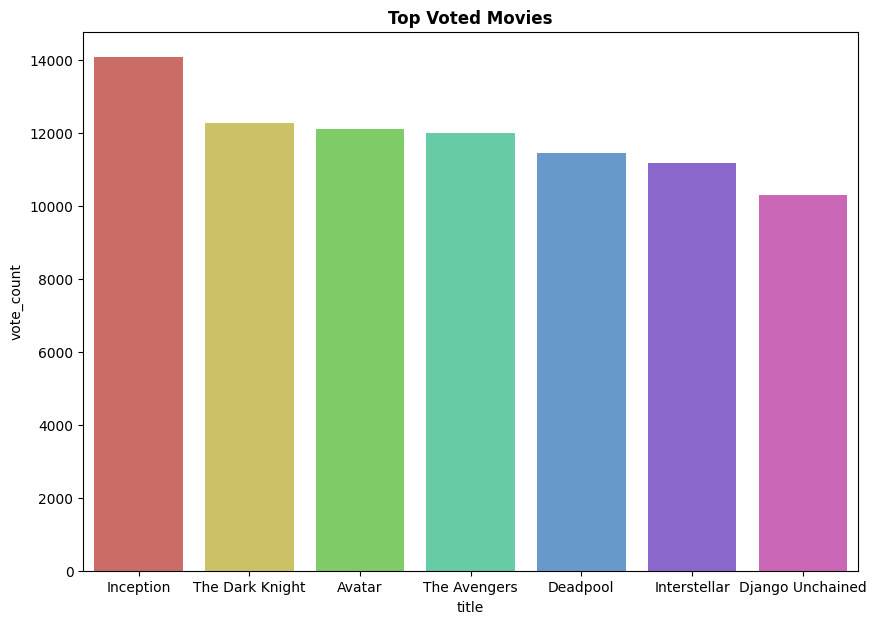

In [ ]:
fig,axs=plt.subplots(figsize=(10,7))
g=sns.barplot(x=top_voted['title'][:7],y=top_voted['vote_count'][:7], palette = 'hls')
g.set_title("Top Voted Movies", weight = "bold")
plt.show()

Promedio de calificaciones de las peliculas mas votadas

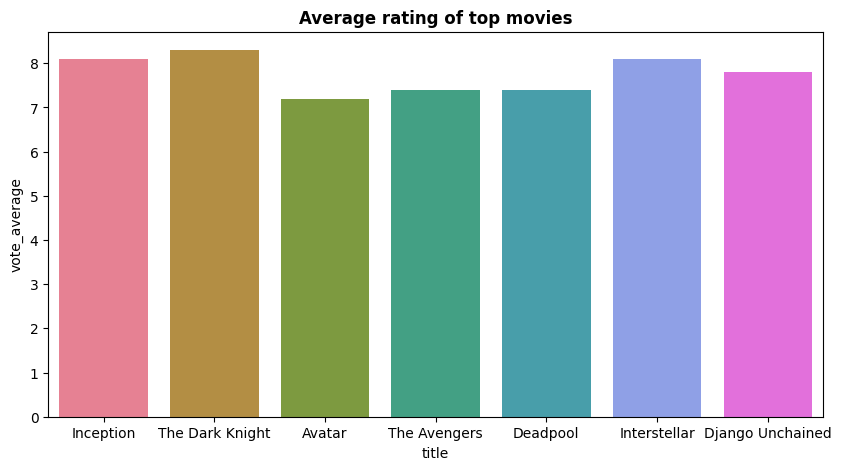

In [ ]:
fig,axs=plt.subplots(figsize=(10,5))
g=sns.barplot(x=top_voted['title'][:7],y=top_voted['vote_average'][:7], palette = 'husl')
g.set_title("Average rating of top movies", weight = "bold")
plt.show()

Popularity

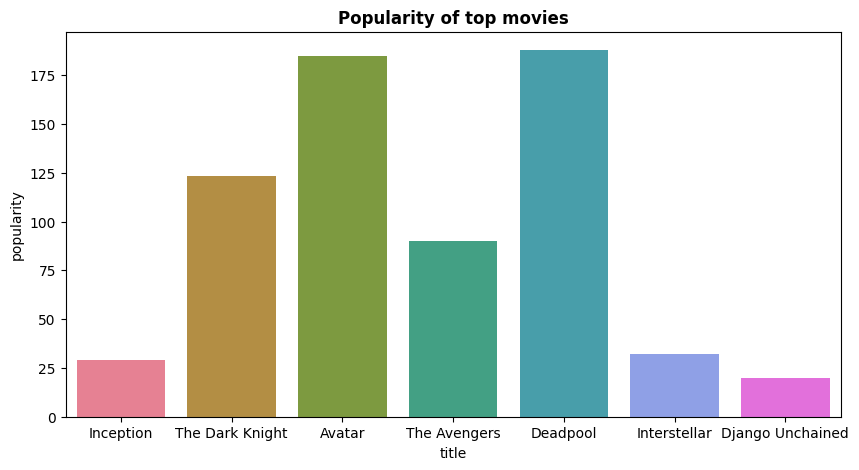

In [ ]:
fig,axs=plt.subplots(figsize=(10,5))
g=sns.barplot(x=top_voted['title'][:7],y=top_voted['popularity'][:7], palette = 'husl')
g.set_title("Popularity of top movies", weight = "bold")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40831 entries, 0 to 59243
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 40831 non-null  object        
 1   budget                40831 non-null  float64       
 2   genres                40831 non-null  object        
 3   id                    40831 non-null  int64         
 4   original_language     40823 non-null  object        
 5   overview              40158 non-null  object        
 6   popularity            40831 non-null  float64       
 7   production_companies  40831 non-null  object        
 8   production_countries  40831 non-null  object        
 9   release_date          40801 non-null  datetime64[ns]
 10  revenue               40831 non-null  float64       
 11  runtime               40660 non-null  float64       
 12  spoken_languages      40831 non-null  object        
 13  tagline         

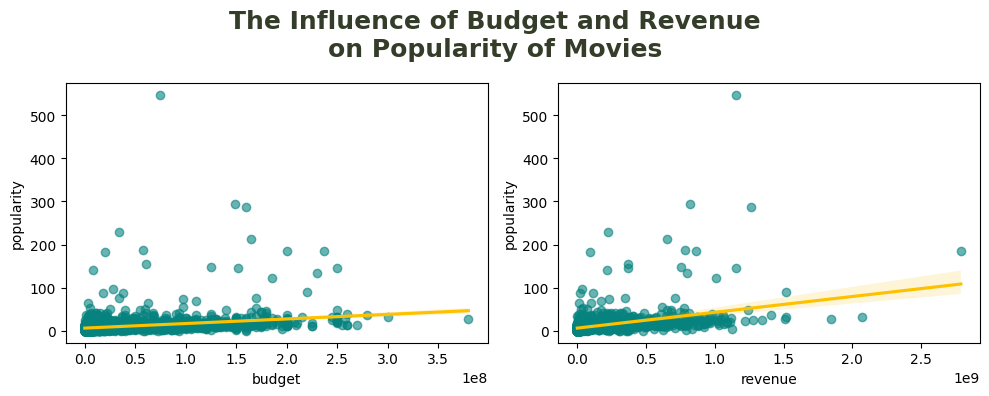

In [ ]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()


Budget y Revenue influye ligeramente en la popularidad de las peliculas

Palabras mas comunes en overviews

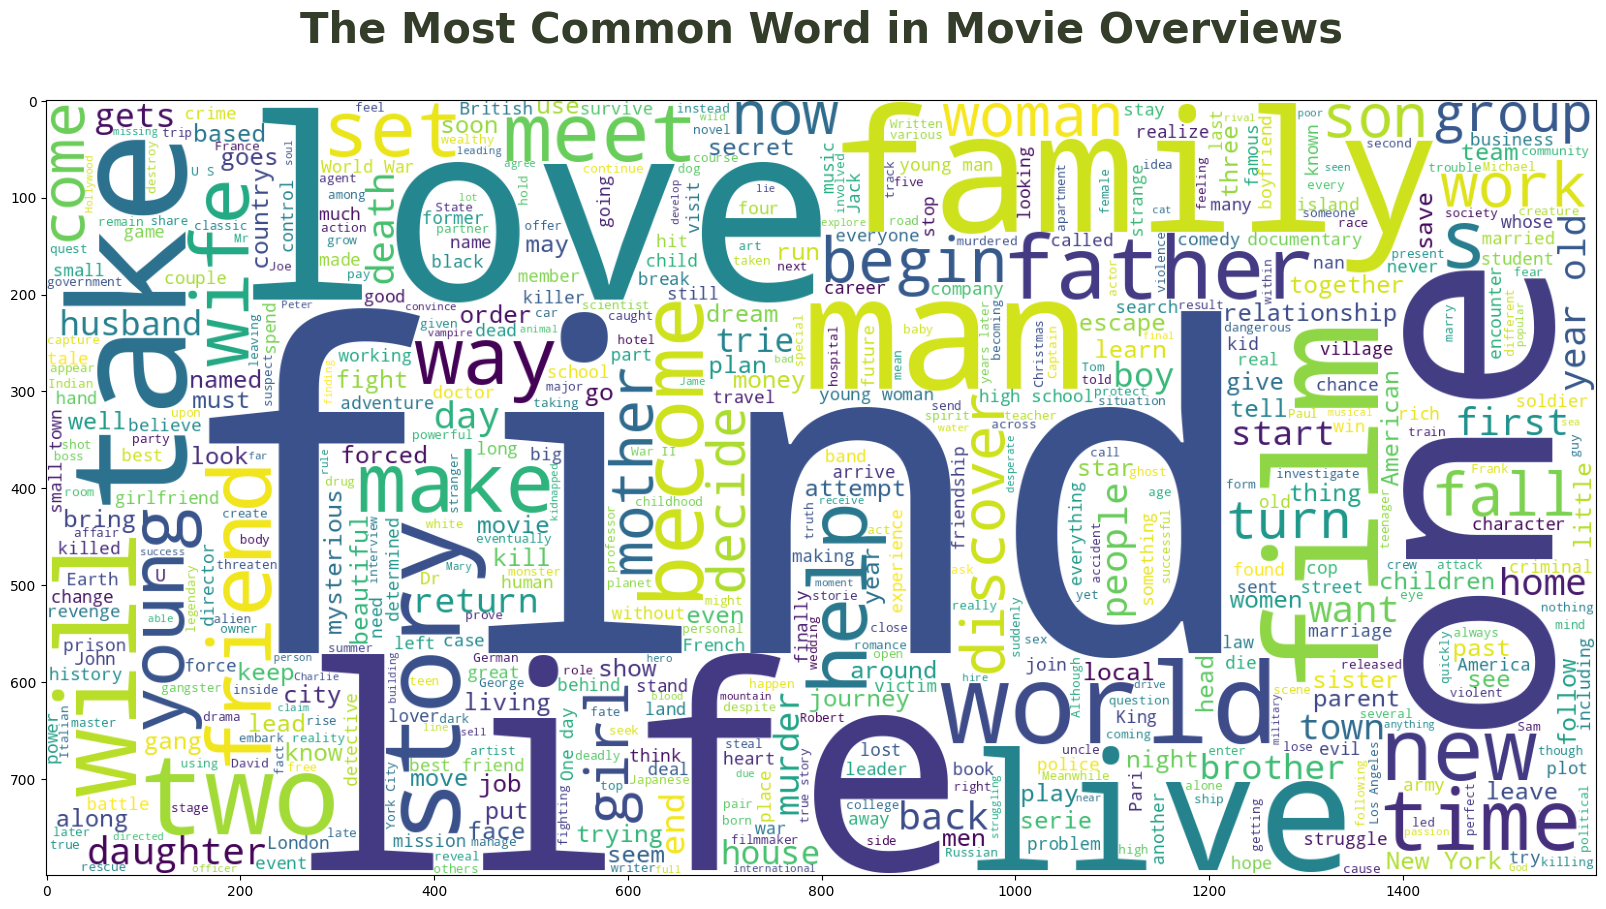

In [ ]:
df['overview'] = df['overview'].astype(str)
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

Distribucion de generos

In [ ]:
df_cp=df.copy()
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)

(-1.25, 1.25, -1.25, 1.25)

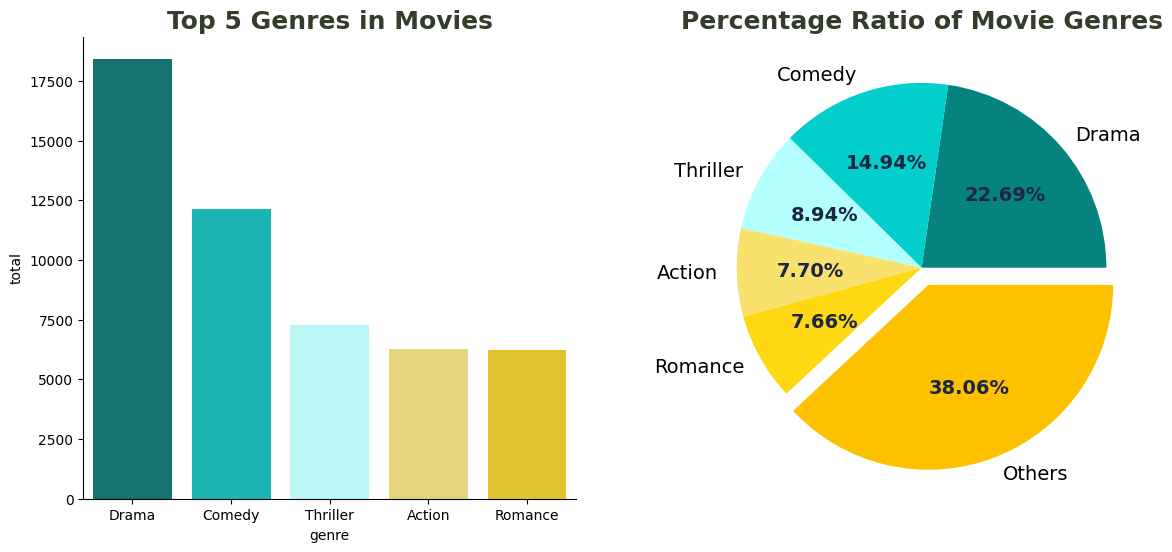

In [ ]:
df['genres'] = df['genres'].astype(str)
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

In [ ]:
countGeneros=df['genres'].value_counts().sort_values(ascending=False)
countGeneros

Drama                                 4359
Comedy                                3240
Documentary                           2196
                                      1773
Drama, Romance                        1199
                                      ... 
Horror, Crime, Drama, Thriller           1
Crime, Mystery, Thriller, Horror         1
Foreign, Romance, Drama                  1
Animation, Adventure, Drama              1
Family, Animation, Romance, Comedy       1
Name: genres, Length: 3899, dtype: int64

Distribucion por calificacion de adulto o no

(0.0, 2.0, 0.9, 1.2)

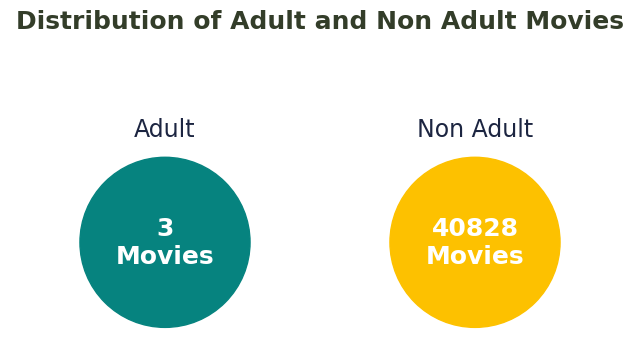

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

Top released by date

Text(0.5, 1.0, 'Total Released Movie by Date')

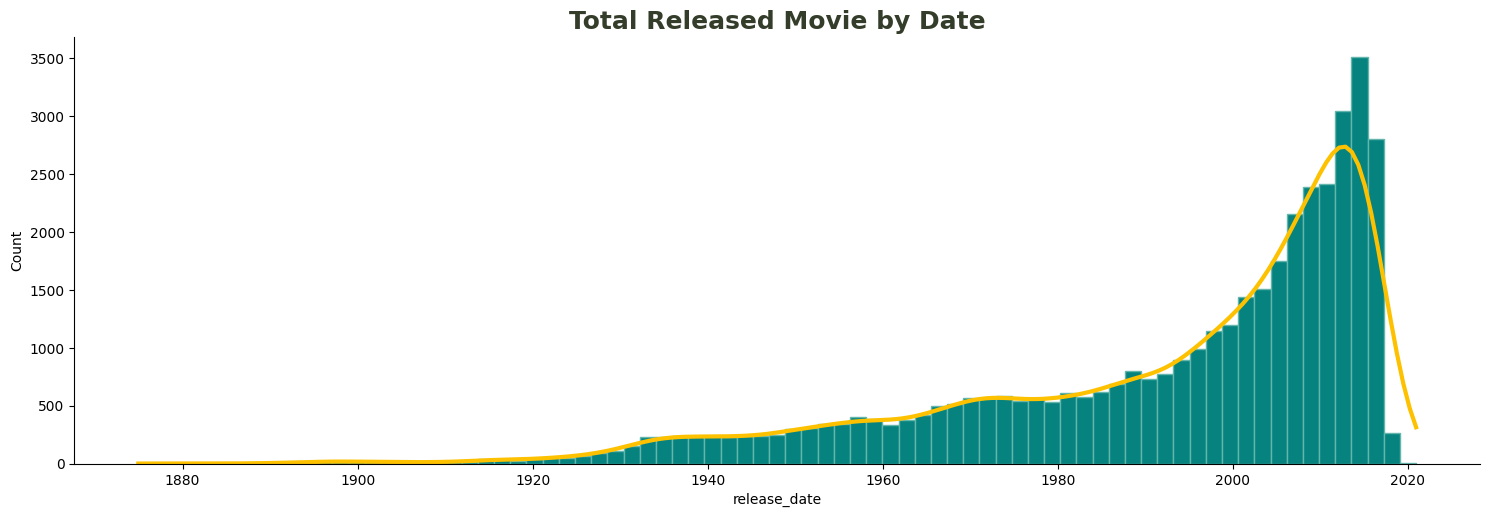

In [ ]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

Distribucion de popularidad, runtime, budget, revenue de top 5 generos

<ipython-input-63-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-63-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-63-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-63-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])


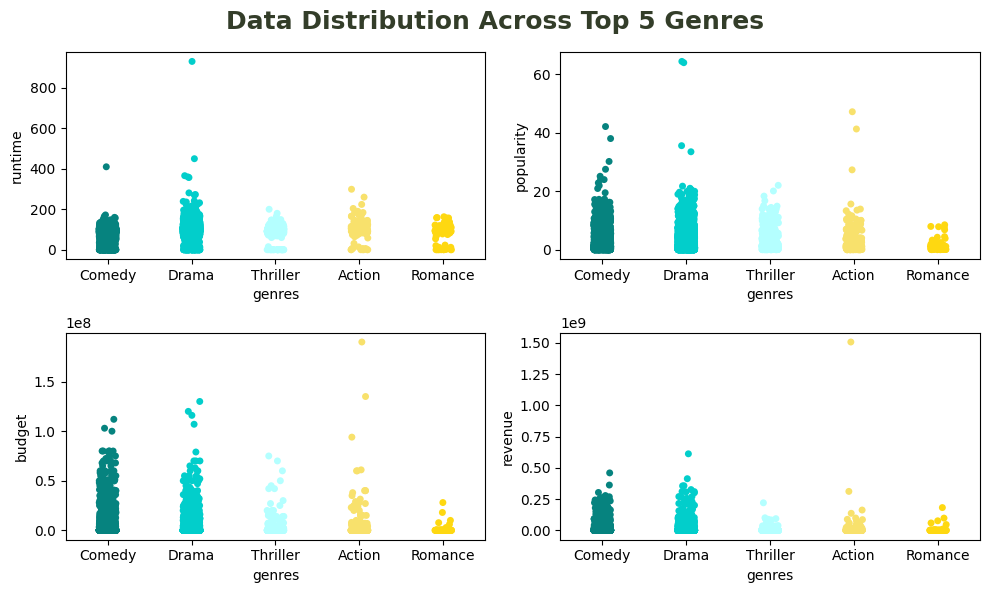

In [ ]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

# **MODELOS DE RECOMENDACION**

## **Recomendador basado en popularidad**

In [ ]:
df= df_cp

In [ ]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
df['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
59237        [Drama, Action, Romance]
59238                         [Drama]
59239       [Action, Drama, Thriller]
59241                              []
59243                              []
Name: genres, Length: 40831, dtype: object


Para generar el recomendador se utilizara la formula de calificación ponderada de IMDB que es representada matemáticamente de la siguiente manera:

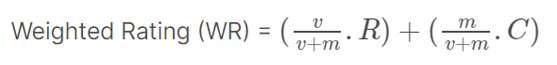

Donde:
•	v es el número de votos de la película
•	m son los votos mínimos necesarios para aparecer en la lista
•	R es la calificación promedio de la película.
•	C es el voto medio en todo el informe. Media de [‘vote_average’].

El siguiente paso es determinar un valor apropiado para m, los votos mínimos necesarios para aparecer en el informe. Usaremos el percentil 95 como límite. En otras palabras, para que una película aparezca en las listas, debe tener más votos que al menos el 95% de las películas de la lista.

In [ ]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.340305160294874

In [ ]:
m = vote_counts.quantile(0.95)
m

502.0

Crear columna year a partir de release_date

In [ ]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2043, 6)

El valor de m es igual a 492 y C= 5.2945, de esta manera, para ser considerada en la lista, una película debe tener al menos 492 votos en [‘vote_count’]. También vemos que la calificación promedio de una película en TMDB es 5.244 en una escala de 10. Así,  2043 películas califican para estar en nuestra tabla.

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False)

In [ ]:
qualified.shape

(2043, 7)

In [ ]:
qualified.head()

,title,year,vote_count,vote_average,popularity,genres,wr
15733,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.908406
12627,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.895453
24500,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.885776
2923,Fight Club,1999,9678,8,63.869599,[Drama],7.868844
4944,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.857870


Ahora es posible  construir una función que genere informes para géneros particulares. Para esto, se relajará las condiciones predeterminadas al percentil 70 en lugar de 95.

In [ ]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = df.drop('genres', axis=1).join(s)

<ipython-input-76-52e5fb4bae5e>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)


In [ ]:
def build_chart(genre, percentile=0.70):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False)

    return qualified

Una vez generada la función, es posible comprobar su funcionamiento mostrando las 15 mejores películas con género de Acción:

**Top Action Movies**

In [ ]:
build_chart('Action').head(15)

,title,year,vote_count,vote_average,popularity,wr
15733,Inception,2010,14075,8,29.108149,7.988585
12627,The Dark Knight,2008,12269,8,123.167259,7.986913
4944,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.981974
7130,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.980525
5930,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.979046
261,Star Wars,1977,6778,8,42.149697,7.976400
1202,The Empire Strikes Back,1980,5998,8,19.470959,7.973361
4225,Scarface,1983,3017,8,11.299673,7.947535
9587,Oldboy,2003,2000,8,10.616859,7.921609
1965,Seven Samurai,1954,892,8,15.017770,7.830181


In [ ]:
build_chart('Animation').head(15)

,title,year,vote_count,vote_average,popularity,wr
364,The Lion King,1994,5520,8,21.605761,7.970535
5577,Spirited Away,2001,3968,8,41.048867,7.959236
9854,Howl's Moving Castle,2004,2049,8,16.136048,7.922475
2965,Princess Mononoke,1997,2041,8,17.166725,7.922182
5949,My Neighbor Totoro,1988,1730,8,13.507299,7.908804
51746,Your Name.,2016,1030,8,34.461252,7.851241
20234,Paperman,2012,734,8,7.198633,7.797081
50410,Piper,2016,487,8,11.243161,7.708528
21352,Wolf Children,2012,483,8,10.249498,7.706453
37921,Feast,2014,420,8,7.365663,7.669392


El recomendador funciona correctamente pero hay que considerar que únicamente tiene en cuenta información de popularidad y género, no considera gustos e intereses personales de cada usuario.

## **CONTENT BASED**

Para personalizar más las recomendaciones se creara un recomendador que calcule la similitud entre películas en función de  ciertas métricas y sugiera o recomiende películas que son más similares a una película en particular que le gustó a un usuario.  Dado que se usará contenido de películas para crear este motor, esto se conoce como filtrado basado en contenido.
Se implementaran 3 recomendadores basados en contenido:
1.	Basado en overviews y taglines
2.	Basado en reparto (cast), crew (equipo), keywords (palabras clave) y genres (genero).
3.	Basado en reparto (cast), crew (equipo), keywords (palabras clave) y genres (genero) y popularidad.

Además, debido a que los algoritmos a utilizar pueden escalar muy rápidamente en consumo de memoria al aplicarlos en grandes conjuntos de datos, se utilizará un subconjunto de todas las películas disponibles realizando merge con el archivo ‘links_small.csv’. De esta manera se redujo la cantidad de películas a 8951.

### **Content Based overviews-taglines**

Se comenzara con el recomendador basado en overviews y taglines

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40831 entries, 0 to 59243
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 40831 non-null  object        
 1   budget                40831 non-null  float64       
 2   genres                40831 non-null  object        
 3   id                    40831 non-null  int64         
 4   original_language     40823 non-null  object        
 5   overview              40831 non-null  object        
 6   popularity            40831 non-null  float64       
 7   production_companies  40831 non-null  object        
 8   production_countries  40831 non-null  object        
 9   release_date          40801 non-null  datetime64[ns]
 10  revenue               40831 non-null  float64       
 11  runtime               40660 non-null  float64       
 12  spoken_languages      40831 non-null  object        
 13  tagline         

In [ ]:
links_small = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/links_small.csv')
# links_small = pd.read_csv("data\links_small.csv")
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
smd = df[df['id'].isin(links_small)]
smd.shape

(8951, 22)

In [ ]:
smd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 52145
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 8951 non-null   object        
 1   budget                8951 non-null   float64       
 2   genres                8951 non-null   object        
 3   id                    8951 non-null   int64         
 4   original_language     8951 non-null   object        
 5   overview              8951 non-null   object        
 6   popularity            8951 non-null   float64       
 7   production_companies  8951 non-null   object        
 8   production_countries  8951 non-null   object        
 9   release_date          8951 non-null   datetime64[ns]
 10  revenue               8951 non-null   float64       
 11  runtime               8951 non-null   float64       
 12  spoken_languages      8951 non-null   object        
 13  tagline          

In [ ]:
df=smd

In [ ]:
df['tagline'] = df['tagline'].fillna('')
df['description'] = df['overview'] + df['tagline']
# df['description'] = df['overview']
df['description'] = df['description'].fillna('')

<ipython-input-87-0ec85e33039e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tagline'] = df['tagline'].fillna('')
<ipython-input-87-0ec85e33039e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['overview'] + df['tagline']
<ipython-input-87-0ec85e33039e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:

train=df

In [ ]:
train.shape

(8951, 23)

In [ ]:
train['description']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
51021    A man must cope with the loss of his wife and ...
51365    Rustom Pavri, an honourable officer of the Ind...
51469    Village lad Sarman is drawn to big, bad Mohenj...
51704    From the mind behind Evangelion comes a hit la...
52145    The band stormed Europe in 1963, and, in 1964,...
Name: description, Length: 8951, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word',min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(train['description'])

In [ ]:
tfidf_matrix.shape

(8951, 29422)

Cosine Similarity

Usaré la similitud del coseno para calcular una cantidad numérica que denota la similitud entre dos películas. Matemáticamente se define de la siguiente manera:

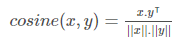

Dado que hemos utilizado el vectorizador TF-IDF, calcular el producto escalar nos dará directamente la puntuación de similitud del coseno. Por lo tanto, usaremos linear_kernel de sklearn en lugar de cosine_similarities ya que es mucho más rápido.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

(8951, 8951)

Una vez calculada la similitud del coseno, se tiene una matriz de similitud de cosenos por pares para todas las películas de nuestro conjunto de datos con dimensionalidad (8951, 8951).

In [ ]:
cosine_sim[0]

array([1.        , 0.01795682, 0.        , ..., 0.        , 0.        ,
       0.01180215])

In [ ]:
train=train.reset_index()
titles = train['title']
indices = pd.Series(train.index, index=train['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

 El siguiente paso es escribir una función que devuelva las películas más similares según la puntuación de similitud del coseno respecto a una película. La función está definida con el nombre ‘get_recommendations2’, la cual en primer lugar obtiene y muestra la imagen del poster del título de la película que se pasa como parámetro. Luego obtiene las puntuaciones de similitud por pares de todas las películas con esa película. Ordena las películas según las puntuaciones de similitud. Obtiene las puntuaciones de las 10 películas más similares, posteriormente calcula los índices de las películas. Se seleccionan las películas más similares del conjunto de datos y se obtienen y muestran las imágenes de sus poster.

In [ ]:
def get_recommendations_Posters(title):
    # Get the index of the movie that matches the title
    idx = train.index[train['title'] == title][0]
    # show given movie poster
    try:
        a = io.imread(f'https://image.tmdb.org/t/p/w500/{train.loc[idx, "poster_path"]}')
        plt.imshow(a)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except:pass

    print('Recommendations\n')


    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:10]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = train.iloc[movie_indices]

    # show reco. movie posters
    fig, ax = plt.subplots(3, 3, figsize=(15,20))
    ax=ax.flatten()
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except: pass
    fig.tight_layout()
    # fig.show()

In [ ]:
get_recommendations('The Dark Knight').head(10)

7822                      The Dark Knight Rises
1095                             Batman Returns
7462                 Batman: Under the Red Hood
8111    Batman: The Dark Knight Returns, Part 2
131                              Batman Forever
8054    Batman: The Dark Knight Returns, Part 1
518                                      Batman
7792                           Batman: Year One
2546               Batman: Mask of the Phantasm
6064                              Batman Begins
Name: title, dtype: object

In [ ]:
get_recommendations_Posters('The Dark Knight')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
get_recommendations_Posters('Avatar')

Output hidden; open in https://colab.research.google.com to view.

Se observa que para The Dark Knight, nuestro sistema es capaz de identificarla como una película de Batman y posteriormente recomendar otras películas de Batman como sus principales recomendaciones. Pero eso es todo lo que este sistema puede hacer por el momento. Esto no es de mucha utilidad para la mayoría de las personas, ya que no tiene en cuenta características muy importantes como el reparto, el equipo, el director y el género, que determinan la calificación y la popularidad de una película.
Por tanto, se utilizará a continuación metadatos mucho más sugerentes que Overview y Tagline. En la siguiente subsección, se creará un recomendador más sofisticado que tenga en cuenta el género, las palabras clave, el reparto y el equipo.

### **Content Based keywords, crew, cast, genres**

En primer lugar, la feature ‘crew’ contiene gran cantidad de datos pero para este trabajo se considera importante el director de la película. Teniendo esto en cuenta, se definió una función que obtiene el director de las películas a partir de la feature [‘crew’]. A su vez, se menciona 3 veces el director con el objetivo de darle más peso al momento de realizar recomendaciones. Con respecto a la feature ‘cast’ se consideró que los primeros 3 actores de reparto son más influyentes.  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 52145
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 8951 non-null   object        
 1   budget                8951 non-null   float64       
 2   genres                8951 non-null   object        
 3   id                    8951 non-null   int64         
 4   original_language     8951 non-null   object        
 5   overview              8951 non-null   object        
 6   popularity            8951 non-null   float64       
 7   production_companies  8951 non-null   object        
 8   production_countries  8951 non-null   object        
 9   release_date          8951 non-null   datetime64[ns]
 10  revenue               8951 non-null   float64       
 11  runtime               8951 non-null   float64       
 12  spoken_languages      8951 non-null   object        
 13  tagline          

In [ ]:
df['cast'] = df['cast'].apply(literal_eval)
df['crew'] = df['crew'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

<ipython-input-112-ea843e799d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = df['cast'].apply(literal_eval)
<ipython-input-112-ea843e799d49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['crew'] = df['crew'].apply(literal_eval)
<ipython-input-112-ea843e799d49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
df['cast_size']

0        13
1        26
2         7
3        10
4        12
         ..
51021     7
51365    14
51469    12
51704    49
52145    28
Name: cast_size, Length: 8951, dtype: int64

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
df['director'] = df['crew'].apply(get_director)

<ipython-input-118-d3f09fd2eb55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df['crew'].apply(get_director)


In [ ]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

<ipython-input-119-faea3781b354>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
<ipython-input-119-faea3781b354>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [ ]:
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

<ipython-input-120-16b6a3b8d1f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [ ]:
df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

<ipython-input-121-31aa4491d4fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


In [ ]:
df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
df['director'] = df['director'].apply(lambda x: [x,x, x])

<ipython-input-122-7f4707f13365>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
<ipython-input-122-7f4707f13365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df['director'].apply(lambda x: [x,x, x])


Keywords

Con respecto a la feature ‘keywords’, se observó que contiene palabras frecuentes que aparecen en frecuencias que van del 1 al 610. Se considerarán aquellas keywords que tengan frecuencia > 1. Posteriormente, se convertirá cada palabra a su stem (raiz) para que palabras como Dogs y Dog se consideren iguales. En palabras simples, stemming es reducir una palabra a su palabra base o raíz de tal manera que las palabras de tipo similar se encuentren bajo una base o raíz común.

In [ ]:
s = df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

<ipython-input-123-adf092d75de5>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


In [ ]:
s = s.value_counts()
s[:5]

independent film        598
woman director          528
murder                  396
duringcreditsstinger    326
based on novel          309
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
df['keywords'] = df['keywords'].apply(filter_keywords)
df['keywords'] = df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
df['keywords'] = df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


<ipython-input-128-2e0aa65ebe2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].apply(filter_keywords)
<ipython-input-128-2e0aa65ebe2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
<ipython-input-128-2e0aa65ebe2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df['keywords'].head()

0    [jealousi, toy, boy, friendship, friend, rival...
1    [boardgam, disappear, basedonchildren'sbook, n...
2               [fish, bestfriend, duringcreditssting]
3    [basedonnovel, interracialrelationship, single...
4    [babi, midlifecrisi, confid, age, daughter, mo...
Name: keywords, dtype: object

In [ ]:
df['cast'].head()


0                  [tomhanks, timallen, donrickles]
1       [robinwilliams, jonathanhyde, kirstendunst]
2          [waltermatthau, jacklemmon, ann-margret]
3    [whitneyhouston, angelabassett, lorettadevine]
4           [stevemartin, dianekeaton, martinshort]
Name: cast, dtype: object

Finalmente se genera una bolsa o sopa de palabras compuesta por ‘keywords’, ‘cast’, ‘director’ y ‘genres’.

In [ ]:

df['soup'] = + df['keywords'] + df['cast'] + df['director'] + df['genres']
df['soup'] = df['soup'].apply(lambda x: ' '.join(x))

<ipython-input-133-5850b179fe23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soup'] = + df['keywords'] + df['cast'] + df['director'] + df['genres']
<ipython-input-133-5850b179fe23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soup'] = df['soup'].apply(lambda x: ' '.join(x))


In [ ]:
df["soup"].head()

0    jealousi toy boy friendship friend rivalri boy...
1    boardgam disappear basedonchildren'sbook newho...
2    fish bestfriend duringcreditssting waltermatth...
3    basedonnovel interracialrelationship singlemot...
4    babi midlifecrisi confid age daughter motherda...
Name: soup, dtype: object

In [ ]:

train=df

In [ ]:
train.shape

(8951, 27)

 Y a continuación el proceso de generar las recomendaciones es similar al anterior, con la diferencia de que en este caso presento mejores resultados el uso de la función CountVectorizer( ) sustituyendo a TF-IDF.

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
count_matrix = count.fit_transform(train['soup'])


In [ ]:
count_matrix.shape

(8951, 106361)

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
cosine_sim.shape

(8951, 8951)

In [ ]:
train=train.reset_index()
titles = train['title']
indices = pd.Series(train.index, index=train['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

7822         The Dark Knight Rises
6064                 Batman Begins
6457                  The Prestige
2037                     Following
7452                     Inception
4055                      Insomnia
3321                       Memento
8382                  Interstellar
7462    Batman: Under the Red Hood
1095                Batman Returns
Name: title, dtype: object

In [ ]:
get_recommendations('Cars')

7705                                            Cars 2
6231                                          Luxo Jr.
0                                            Toy Story
2471                                       Toy Story 2
1836                                      A Bug's Life
8763                                           Minions
7921     The Pirates! In an Adventure with Scientists!
7658                                               Rio
4111                            The Master of Disguise
8410                                             Rio 2
8146                                        The Croods
7300           Alvin and the Chipmunks: The Squeakquel
6981                           Beverly Hills Chihuahua
8241                                            Planes
4056                  Spirit: Stallion of the Cimarron
2116             Austin Powers: The Spy Who Shagged Me
7046                              Paul Blart: Mall Cop
8581                            Penguins of Madagascar
4803      

In [ ]:
get_recommendations('Avatar')

935                                        Aliens
516                    Terminator 2: Judgment Day
972                                The Terminator
886                                     The Abyss
4247               Piranha Part Two: The Spawning
340                                     True Lies
1333                                      Titanic
8174                      Star Trek Into Darkness
3159                           Dungeons & Dragons
8491                            Jupiter Ascending
1454                               Small Soldiers
7090                         Dragonball Evolution
3004              Sinbad and the Eye of the Tiger
4855                         Hercules in New York
5933    Beastmaster 2: Through the Portal of Time
8192                                 Man of Steel
1622                   Return from Witch Mountain
3935                              Hawk the Slayer
2084                                  Superman II
8426                   X-Men: Days of Future Past


In [ ]:
get_recommendations_Posters('X-Men: Days of Future Past')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
get_recommendations_Posters('Avatar')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
get_recommendations_Posters('Toy Story')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
get_recommendations_Posters('The Dark Knight')

Output hidden; open in https://colab.research.google.com to view.

Este motor ha logrado mejorar las recomendaciones, de manera tal que para la pelicula 'The Dark Knight' recomienda otras películas del director Christopher Nolan (debido a la frecuencia que aparece ‘director’ en la bolsa de palabras).

### **Content based y popularidad**

Una notable observación acerca del motor anterior es que recomienda películas independientemente de su popularidad y calificaciones. Por tanto, es posible agregar un filtro de películas por rating utilizando el mismo mecanismo que se utilizó previamente en el recomendador por popularidad. Al implementarlo y ejecutarlo se obtiene el siguiente resultado:

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = train.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.70)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

<ipython-input-223-05fe049e06f5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-223-05fe049e06f5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-223-05fe049e06f5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,title,vote_count,vote_average,year,wr
7452,Inception,14075,8,2010,7.908406
8382,Interstellar,11187,8,2014,7.885776
6457,The Prestige,4510,8,2006,7.733606
3321,Memento,4168,8,2000,7.714097
7822,The Dark Knight Rises,9263,7,2012,6.914678
6064,Batman Begins,7511,7,2005,6.896023
1095,Batman Returns,1706,6,1992,5.850015
8779,Batman v Superman: Dawn of Justice,7189,5,2016,5.022212


El resultado es el esperado, claramente capta la esencia de 'The Dark Knight' y recomienda peliculas similares de Batman y también peliculas del director Christopher Nolan y a su vez son representadas en orden por la popularidad calculada por ‘wr’.

In [ ]:
improved_recommendations('Avatar')

<ipython-input-195-a7fbaf0d9bdd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,title,vote_count,vote_average,year,wr
1333,Titanic,7770,7,1997,6.899279
8426,X-Men: Days of Future Past,6155,7,2014,6.874844
8174,Star Trek Into Darkness,4479,7,2013,6.832731
516,Terminator 2: Judgment Day,4274,7,1991,6.825551
972,The Terminator,4208,7,1984,6.823107
935,Aliens,3282,7,1986,6.779818
886,The Abyss,822,7,1989,6.370720
8192,Man of Steel,6462,6,2013,5.952446
340,True Lies,1138,6,1994,5.798069
8491,Jupiter Ascending,2816,5,2015,5.051487


In [ ]:
improved_recommendations('Star Wars')

<ipython-input-195-a7fbaf0d9bdd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,title,vote_count,vote_average,year,wr
931,The Empire Strikes Back,5998,8,1980,7.794590
8624,Star Wars: The Force Awakens,7993,7,2015,6.901923
8631,Captain America: Civil War,7462,7,2016,6.895383
944,Return of the Jedi,4763,7,1983,6.841754
6045,Star Wars: Episode III - Revenge of the Sith,4200,7,2005,6.822806
7406,Iron Man 2,6969,6,2010,5.955673
8351,Divergent,4784,6,2014,5.937350
2072,Star Wars: Episode I - The Phantom Menace,4526,6,1999,5.934135
2993,X-Men,4172,6,2000,5.929147
4047,Star Wars: Episode II - Attack of the Clones,4074,6,2002,5.927630


In [ ]:
improved_recommendations('Toy Story')

<ipython-input-195-a7fbaf0d9bdd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,title,vote_count,vote_average,year,wr
3752,"Monsters, Inc.",6150,7,2001,6.874749
7434,Toy Story 3,4710,7,2010,6.840145
2471,Toy Story 2,3914,7,1999,6.811330
8364,The Lego Movie,3127,7,2014,6.770414
6338,Cars,3991,6,2006,5.926293
1836,A Bug's Life,2379,6,1998,5.885051
7214,Cloudy with a Chance of Meatballs,1799,6,2009,5.856077
1786,Antz,1320,6,1998,5.818240
2960,Chicken Run,1190,6,2000,5.804275
7705,Cars 2,2088,5,2011,5.065959


In [ ]:
improved_recommendations('Iron Man')

<ipython-input-195-a7fbaf0d9bdd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-195-a7fbaf0d9bdd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,title,vote_count,vote_average,year,wr
7760,The Avengers,12000,7,2012,6.933357
8479,Guardians of the Galaxy,10014,7,2014,6.920772
8631,Captain America: Civil War,7462,7,2016,6.895383
8627,Avengers: Age of Ultron,6908,7,2015,6.887562
8628,Ant-Man,6029,7,2015,6.872429
8395,Captain America: The Winter Soldier,5881,7,2014,6.869471
8165,Iron Man 3,8951,6,2013,5.964967
7714,Captain America: The First Avenger,7174,6,2011,5.956857
7406,Iron Man 2,6969,6,2010,5.955673
7660,Thor,6678,6,2011,5.953876


## **Collaborative filtering**

El motor basado en contenido sufre algunas limitaciones. Sólo es capaz de sugerir películas cercanas a una determinada película. Es decir, el motor no es capaz de realizar recomendaciones personalizadas para cada usuario. Cualquier usuario que consulte el motor para obtener recomendaciones basadas en una película recibirá las mismas recomendaciones para esa película, independientemente de quién sea.
Por tanto, en esta sección se utilizará una técnica llamada Collaborative filtering  (filtrado colaborativo) para hacer recomendaciones a los espectadores de películas. El filtrado colaborativo se basa en la idea de que se pueden utilizar usuarios similares (que ya han usado/experimentado un producto o servicio) para predecir cuánto le gustará en particular a un usuario que no lo usado/experimentado.  
Se utilizará la librería Surprise que utiliza algoritmos potentes como la descomposición de valores singulares (SVD) para minimizar el RMSE (error cuadrático medio) y dar excelentes recomendaciones.


In [ ]:
reader = Reader()

En esta sección es necesario el uso del archivo ‘ratings_small.csv’, el cual contiene información de calificaciones otorgadas a películas por diferentes usuarios. El mismo está compuesto de  100.004 calificaciones.

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Proyecto ia2/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

se divide el conjunto de datos en train y test (utilizando una función otorgada por Surprise denominada ‘train_test_split’). A continuación se ejecuta el modelo SVD() sobre el conjunto de datos de train.

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)

Y al realizar la prueba sobre el conjunto de test se obtiene RMSE= 0.88943

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.8894


0.8894360610956544

In [ ]:
svd_model.predict(uid=1.0, iid=541, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 3.24   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=3.2413932933660945, details={'was_impossible': False})

Una vez generado el modelo, es posible realizar predicciones con respecto a un número de usuario (‘userId’) y un número de película (‘movieId’). Esto es muy útil pero si se combina con Content Based podría crearse un modelo mucho más eficiente, eso es lo que se tratará de implementar en la siguiente sección.

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
trainset = data.build_full_trainset()

## **Modelo Hibrido**

En esta sección, se intentará crear un recomendador híbrido que reúna las técnicas que se han implementado en los motores basados en contenido y en filtros colaborativos. Así es como funcionará:

Entrada: ID de usuario y título de una película

Salida: Películas similares clasificadas según las calificaciones esperadas por ese usuario en particular analizando usuarios similares aplicando SVD ().


In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
smd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 52145
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 8951 non-null   object        
 1   budget                8951 non-null   float64       
 2   genres                8951 non-null   object        
 3   id                    8951 non-null   int64         
 4   original_language     8951 non-null   object        
 5   overview              8951 non-null   object        
 6   popularity            8951 non-null   float64       
 7   production_companies  8951 non-null   object        
 8   production_countries  8951 non-null   object        
 9   release_date          8951 non-null   datetime64[ns]
 10  revenue               8951 non-null   float64       
 11  runtime               8951 non-null   float64       
 12  spoken_languages      8951 non-null   object        
 13  tagline          

In [ ]:

id_map =pd.read_csv('/content/drive/MyDrive/Proyecto ia2/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

En primer lugar se  obtiene el índice de la película y su  similitud de coseno con respecto a las demás películas. Se ordena por similitud y se toman las primeras 30 películas.  A continuación se calcula la predicción  de calificación del usuario en base a SVD () y se ordena por las estimaciones.

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    # tmdbId = id_map.loc[title]['id']
    #print(idx)
    # movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd_model.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'The Dark Knight')

,title,vote_count,vote_average,year,id,est
24500,Interstellar,11187.0,8.1,2014,157336,3.368653
15733,Inception,14075.0,8.1,2010,27205,3.258965
4180,Memento,4168.0,8.1,2000,77,3.120872
18502,The Dark Knight Rises,9263.0,7.6,2012,49026,3.107251
11522,The Prestige,4510.0,8.0,2006,1124,3.056074
13165,RockNRolla,851.0,6.9,2008,13809,3.026510
15149,Harry Brown,351.0,6.7,2009,25941,2.836419
9305,Thursday,84.0,7.0,1998,9812,2.809066
2534,Following,363.0,7.2,1998,11660,2.804952
42666,İtirazım Var,9.0,7.1,2014,265351,2.796642


In [ ]:
hybrid(400, 'The Dark Knight')

,title,vote_count,vote_average,year,id,est
15733,Inception,14075.0,8.1,2010,27205,4.292930
24500,Interstellar,11187.0,8.1,2014,157336,4.232603
11522,The Prestige,4510.0,8.0,2006,1124,4.201943
4180,Memento,4168.0,8.1,2000,77,4.134972
18502,The Dark Knight Rises,9263.0,7.6,2012,49026,4.124393
10275,Batman Begins,7511.0,7.5,2005,272,4.070912
13165,RockNRolla,851.0,6.9,2008,13809,3.770813
9305,Thursday,84.0,7.0,1998,9812,3.757932
15149,Harry Brown,351.0,6.7,2009,25941,3.755736
2534,Following,363.0,7.2,1998,11660,3.750251


Es observable que el recomendador híbrido, obtiene diferentes recomendaciones para diferentes usuarios aunque la película sea la misma. Por lo tanto, las recomendaciones son más personalizadas y adaptadas a usuarios particulares.